In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [0]:
peaks = lambda x, y: 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2) - 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2 - y**2)
def f(X):
  if X.ndim == 1:
    return peaks(X[0], X[1])
  else:
    return peaks(X[:, 0], X[:, 1])

## Grid search

In [0]:
xx, yy = np.meshgrid(np.arange(-3, 3, .1),
                      np.arange(-3, 3, .1))
coords = np.c_[xx.ravel(), yy.ravel()]
Z = f(coords).reshape(xx.shape)

Examined 3600 points


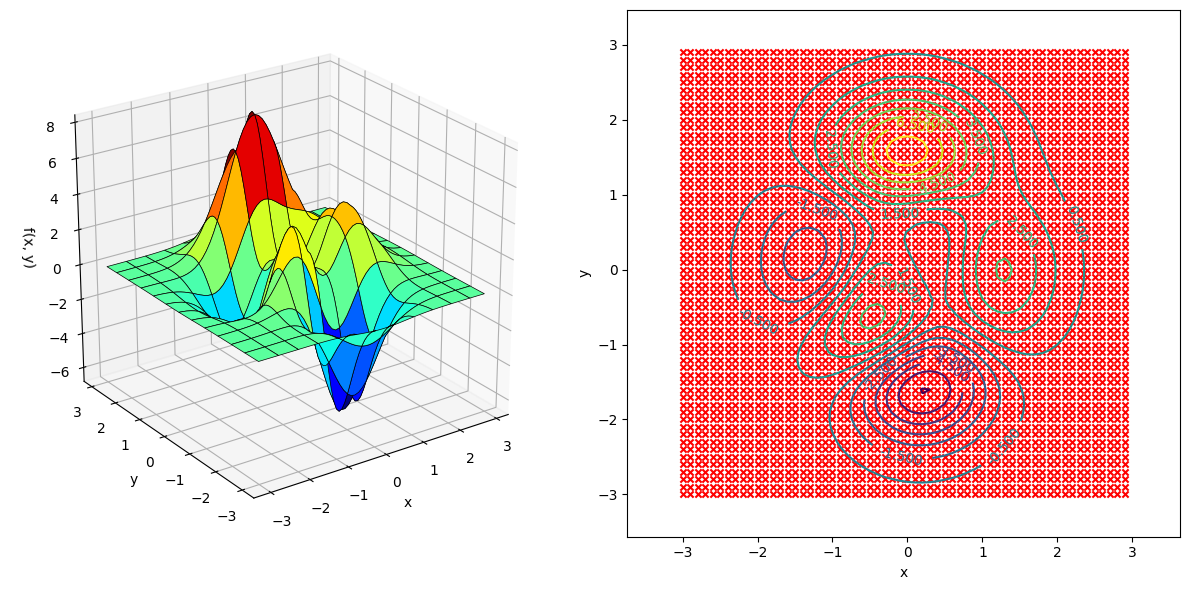

In [0]:
fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx, yy, Z, rstride=5, cstride=5, cmap='jet', linewidth=0.5, edgecolors='k')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.view_init(25, -125)
ax = fig.add_subplot(1, 2, 2)
cs = ax.contour(xx, yy, Z, cmap='viridis', levels=np.arange(-6.5, 8, 1))
ax.clabel(cs, inline=1, fontsize=10)
ax.scatter(xx.ravel(), yy.ravel(), s=20, c='r', marker='x')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
fig.tight_layout()
fig.show()
print("Examined %i points" % len(Z.ravel()))

## Random sampling



In [0]:
n_random_samples = 100

X = np.random.uniform(-3, 3, size=(n_random_samples, 2))
y = f(X)

from scipy.interpolate import griddata
Z_pred = griddata(X, y, (xx, yy), method='linear')
Z_pred_fallback = griddata(X, y, (xx, yy), method='nearest')
Z_pred[np.isnan(Z_pred)] = Z_pred_fallback[np.isnan(Z_pred)]

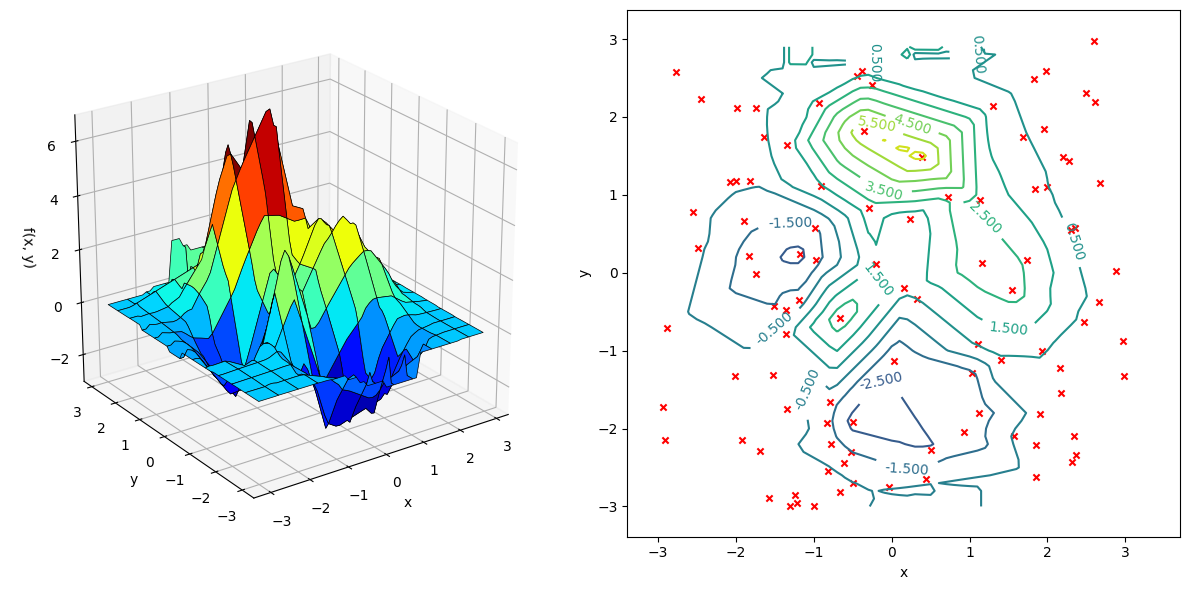

In [0]:
fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx, yy, Z_pred, rstride=5, cstride=5, cmap='jet', linewidth=0.5, edgecolors='k')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.view_init(25, -125)
ax = fig.add_subplot(1, 2, 2)
# cs = ax.contour(xx, yy, np.abs(Z-Z_pred), cmap='viridis', levels=np.arange(-6.5, 8, 1))
cs = ax.contour(xx, yy, Z_pred, cmap='viridis', levels=np.arange(-6.5, 8, 1))
ax.clabel(cs, inline=1, fontsize=10)
ax.scatter(X[:, 0], X[:, 1], s=20, c='r', marker='x')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
fig.tight_layout()
plt.show()

## Surrogate model

In [0]:
n_initial_samples = 20
n_samples = 30
kappa = 1

X = np.random.uniform(-3, 3, size=(n_initial_samples, 2))
y = f(X)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
gpr = GaussianProcessRegressor(kernel=Matern() + WhiteKernel())

picked_grid_points = list()
for i in range(n_initial_samples, n_samples):
  gpr.fit(X, y)
  mu_pred, sigma_pred = gpr.predict(coords, return_std=True)
  sorted_indices = np.argsort(mu_pred + kappa*sigma_pred)
  #sorted_indices = np.argsort(sigma_pred)
  m = [idx for idx in sorted_indices if idx not in picked_grid_points][-1] # low to high
  X = np.concatenate((X, [coords[m, :]]))
  y = f(X)

Z_pred = gpr.predict(coords)
Z_pred = Z_pred.reshape(xx.shape)
#Z_pred = sigma_pred.reshape(xx.shape)

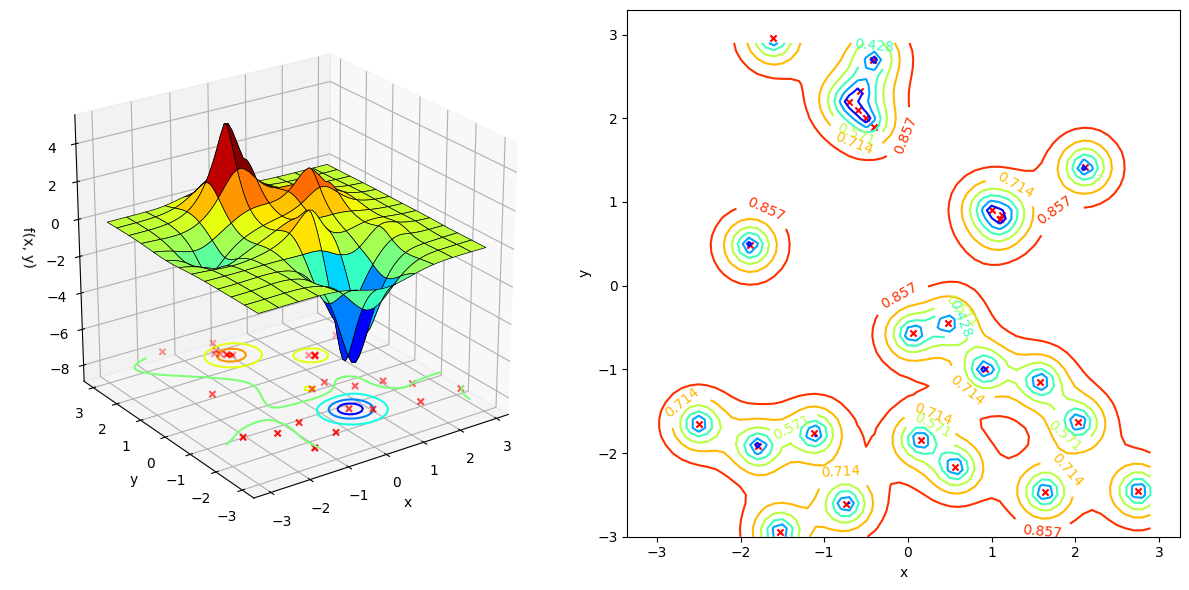

In [0]:
fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx, yy, Z_pred, rstride=5, cstride=5, cmap='jet', linewidth=0.5, edgecolors='k')
ax.contour(xx, yy, Z_pred, cmap='jet', offset=-8)
ax.scatter(X[:, 0], X[:, 1], -8, s=20, c='r', marker='x')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.view_init(25, -125)
ax = fig.add_subplot(1, 2, 2)
#cs = ax.contour(xx, yy, np.abs(Z-Z_pred), cmap='viridis', levels=np.arange(-6.5, 8, 1))
cs = ax.contour(xx, yy, sigma_pred.reshape(xx.shape), cmap='jet', levels=np.linspace(0, np.max(sigma_pred), 8))
ax.clabel(cs, inline=1, fontsize=10)
ax.scatter(X[:, 0], X[:, 1], s=20, c='r', marker='x')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
fig.tight_layout()
fig.show()